# Hyperparameter Tuning for ICU Stay Prediction Models

**Purpose**: Optimize model hyperparameters using the validation set to improve prediction performance.

## Current Model Performance (Baseline):
- **Random Forest**: Test F1 = 0.6883 (best current model)
- **Gradient Boosting**: Test F1 = 0.6811
- **Logistic Regression**: Test F1 = 0.6673
- **SGD Classifier**: Test F1 = 0.5752

## Tuning Strategy:
1. Use **validation set** for hyperparameter search (NOT test set!)
2. Test both **Grid Search** and **Randomized Search**
3. Evaluate final tuned models on **held-out test set**
4. Document best hyperparameters for reproducibility

## Expected Improvements:
- Random Forest: +1-3% (target: 0.70-0.71 F1)
- Gradient Boosting: +2-4% (target: 0.70-0.71 F1)
- Logistic Regression: +1-2% (target: 0.68-0.69 F1)

---

**Note**: This notebook provides ready-to-run code. Hyperparameter tuning is computationally expensive,
so run selectively based on priority (start with Random Forest and Gradient Boosting).

In [1]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import make_scorer, f1_score, classification_report

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Use macro F1 as primary metric
f1_scorer = make_scorer(f1_score, average='macro')

## 1. Load Data and Create Splits

In [2]:
# Load data
conn = duckdb.connect("../../data/duckdb/fedlearn.duckdb", read_only=True)
df = conn.execute("select * from v_features_icu_stay_clean").df()
df = df.where(df.notna(), np.nan)

print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")

# Prepare target and features
y = df["prolonged_stay"]
X = df.drop(columns=["patientunitstayid", "los_days", "prolonged_stay", "apacheadmissiondx"])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Total samples: 199,646
Total features: 103

Feature matrix shape: (199646, 99)
Target distribution:
prolonged_stay
0    0.752362
1    0.247638
Name: proportion, dtype: float64


In [3]:
def build_preprocessor(X):
    """Build preprocessing pipeline."""
    numeric_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(exclude=["number"]).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", numeric_transformer, numeric_features),
            ("categorical", categorical_transformer, categorical_features),
        ],
    )

    return preprocessor

In [4]:
# Create train/val/test split (60/20/20)
# First split: 80/20 (train+val / test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75/25 of remaining (60/20 of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Dataset split sizes:")
print(f"  Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\nIMPORTANT: Hyperparameter tuning uses VALIDATION set, final evaluation uses TEST set.")

Dataset split sizes:
  Training:   119,787 samples (60.0%)
  Validation: 39,929 samples (20.0%)
  Test:       39,930 samples (20.0%)

IMPORTANT: Hyperparameter tuning uses VALIDATION set, final evaluation uses TEST set.


## 2. Random Forest Hyperparameter Tuning

**Current Parameters**:
- n_estimators=100
- max_depth=10
- min_samples_split=20
- min_samples_leaf=10

**Parameters to Tune**:
- n_estimators: [100, 200, 300]
- max_depth: [8, 10, 12, 15]
- min_samples_split: [10, 20, 30]
- min_samples_leaf: [5, 10, 15]

In [5]:
# Define Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", build_preprocessor(X)),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )),
])

# Define parameter grid
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [8, 10, 12, 15],
    'classifier__min_samples_split': [10, 20, 30],
    'classifier__min_samples_leaf': [5, 10, 15],
}

print("Random Forest Parameter Grid:")
print(f"Total combinations: {3 * 4 * 3 * 3} = 108")
print("\nParameter ranges:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

Random Forest Parameter Grid:
Total combinations: 108 = 108

Parameter ranges:
  classifier__n_estimators: [100, 200, 300]
  classifier__max_depth: [8, 10, 12, 15]
  classifier__min_samples_split: [10, 20, 30]
  classifier__min_samples_leaf: [5, 10, 15]


In [6]:
# Option 1: Grid Search (exhaustive, slower)
print("Starting Random Forest Grid Search...")
print("This may take 30-60 minutes depending on your hardware.\n")

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

# Fit on train set, validate on val set
t0 = perf_counter()
rf_grid_search.fit(X_train, y_train)
rf_grid_time = perf_counter() - t0

print(f"\nGrid Search completed in {rf_grid_time:.1f} seconds ({rf_grid_time/60:.1f} minutes)")
print(f"\nBest parameters: {rf_grid_search.best_params_}")
print(f"Best CV F1 score: {rf_grid_search.best_score_:.4f}")

Starting Random Forest Grid Search...
This may take 30-60 minutes depending on your hardware.

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Grid Search completed in 1562.4 seconds (26.0 minutes)

Best parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best CV F1 score: 0.7065


In [7]:
# Evaluate best Random Forest on validation set
rf_best = rf_grid_search.best_estimator_

# Validation performance
y_val_pred = rf_best.predict(X_val)
rf_val_f1 = f1_score(y_val, y_val_pred, average='macro')

print("Random Forest - Best Model Performance:")
print("=" * 50)
print(f"Validation F1: {rf_val_f1:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=['Not Prolonged', 'Prolonged']))

Random Forest - Best Model Performance:
Validation F1: 0.7062

Classification Report (Validation):
               precision    recall  f1-score   support

Not Prolonged       0.86      0.82      0.84     30041
    Prolonged       0.53      0.61      0.57      9888

     accuracy                           0.77     39929
    macro avg       0.70      0.72      0.71     39929
 weighted avg       0.78      0.77      0.78     39929



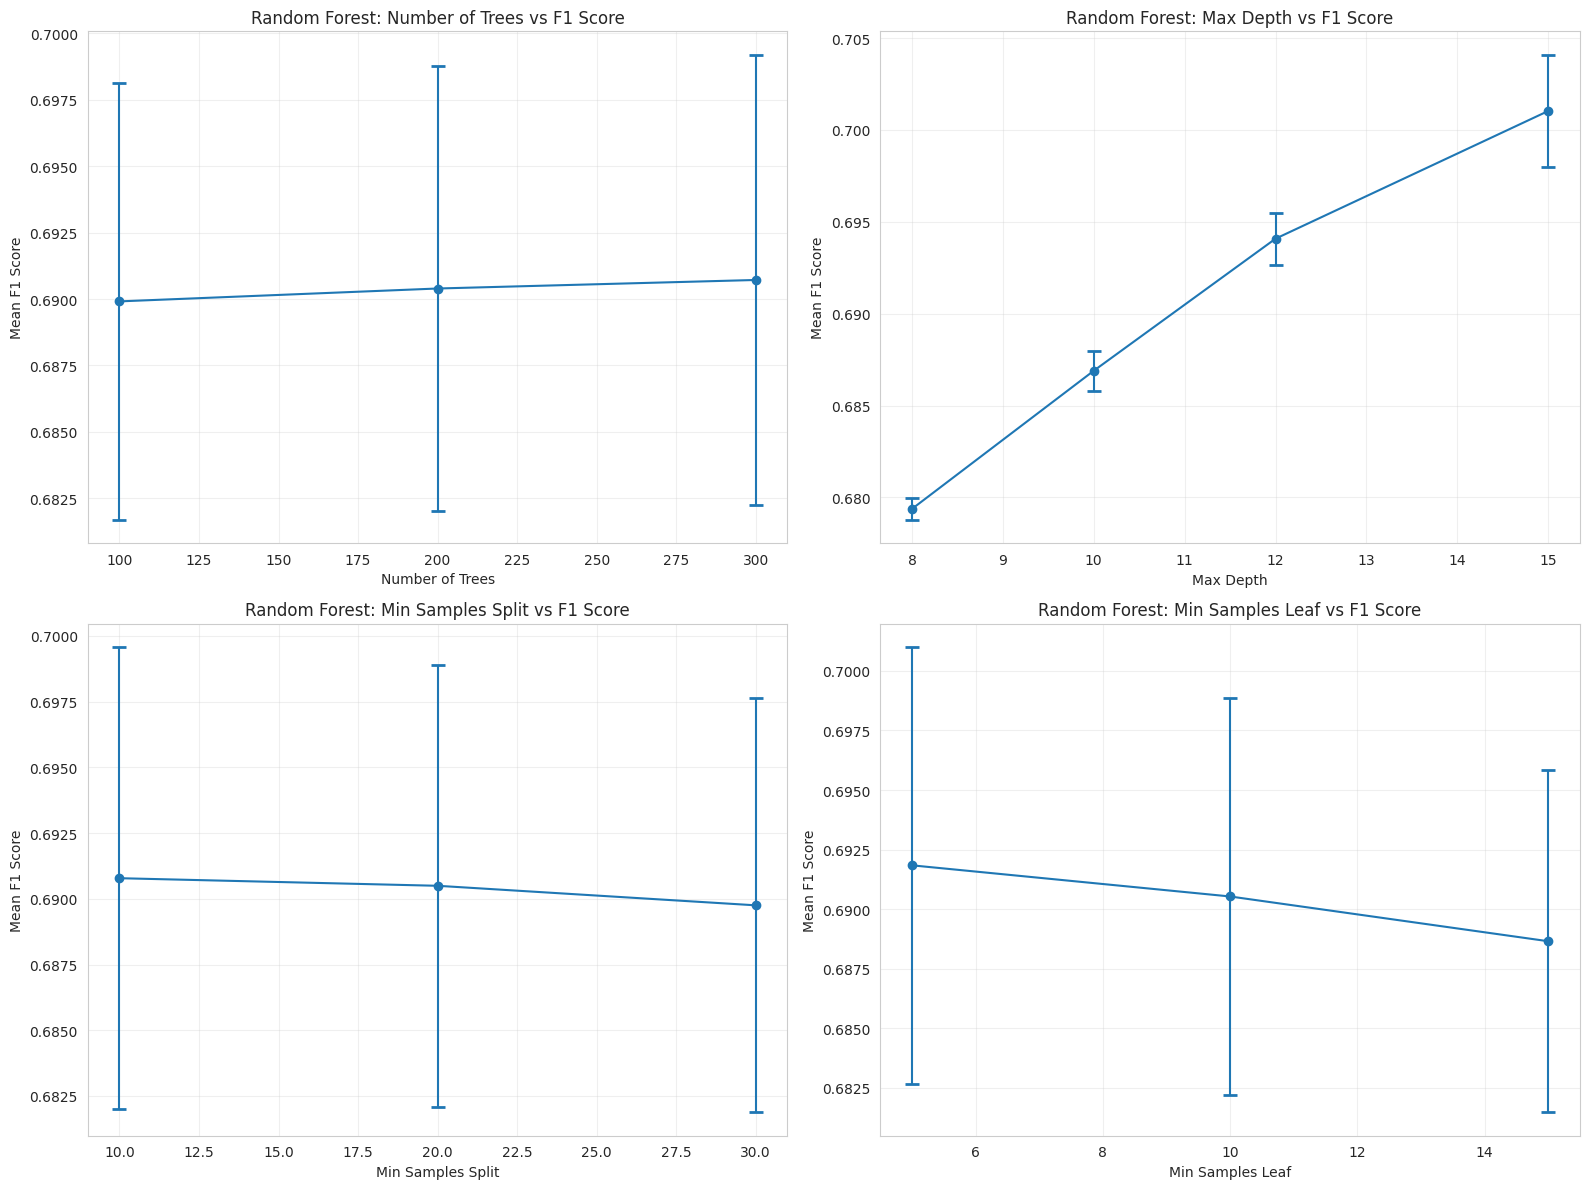

In [8]:
# Visualize Grid Search results
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Plot mean test score vs parameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

params_to_plot = [
    ('classifier__n_estimators', 'Number of Trees'),
    ('classifier__max_depth', 'Max Depth'),
    ('classifier__min_samples_split', 'Min Samples Split'),
    ('classifier__min_samples_leaf', 'Min Samples Leaf'),
]

for idx, (param, label) in enumerate(params_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Group by parameter and get mean score
    grouped = rf_results.groupby(f'param_{param}')['mean_test_score'].agg(['mean', 'std'])
    
    ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                marker='o', capsize=5, capthick=2)
    ax.set_xlabel(label)
    ax.set_ylabel('Mean F1 Score')
    ax.set_title(f'Random Forest: {label} vs F1 Score')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Gradient Boosting Hyperparameter Tuning

**Current Parameters**:
- n_estimators=100
- max_depth=5
- learning_rate=0.1
- min_samples_split=20
- min_samples_leaf=10

**Parameters to Tune**:
- n_estimators: [100, 200, 300]
- max_depth: [3, 5, 7]
- learning_rate: [0.05, 0.1, 0.2]
- subsample: [0.8, 0.9, 1.0]

In [9]:
# Define Gradient Boosting pipeline
gb_pipeline = Pipeline([
    ("preprocessor", build_preprocessor(X)),
    ("classifier", GradientBoostingClassifier(
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
    )),
])

# Define parameter grid
gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
}

print("Gradient Boosting Parameter Grid:")
print(f"Total combinations: {3 * 3 * 3 * 3} = 81")
print("\nParameter ranges:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

Gradient Boosting Parameter Grid:
Total combinations: 81 = 81

Parameter ranges:
  classifier__n_estimators: [100, 200, 300]
  classifier__max_depth: [3, 5, 7]
  classifier__learning_rate: [0.05, 0.1, 0.2]
  classifier__subsample: [0.8, 0.9, 1.0]


In [10]:
# Option 2: Randomized Search (faster, still effective)
print("Starting Gradient Boosting Randomized Search...")
print("Testing 30 random combinations (faster than exhaustive grid search).\n")

gb_random_search = RandomizedSearchCV(
    gb_pipeline,
    gb_param_grid,
    n_iter=30,  # Try 30 random combinations
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

t0 = perf_counter()
gb_random_search.fit(X_train, y_train)
gb_search_time = perf_counter() - t0

print(f"\nRandomized Search completed in {gb_search_time:.1f} seconds ({gb_search_time/60:.1f} minutes)")
print(f"\nBest parameters: {gb_random_search.best_params_}")
print(f"Best CV F1 score: {gb_random_search.best_score_:.4f}")

Starting Gradient Boosting Randomized Search...
Testing 30 random combinations (faster than exhaustive grid search).

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=5, classifier__min_samples_split=10, classifier__n_estimators=200; total time= 1.0min
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=5, classifier__min_samples_split=30, classifier__n_estimators=200; total time=  41.4s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=10, classifier__min_samples_split=20, classifier__n_estimators=200; total time=  33.7s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=15, classifier__min_samples_split=10, classifier__n_estimators=100; total time=  30.2s
[CV] END classifier__max_depth=8, classifier__min_samples_leaf=15, classifier__min_samples_split=20, classifier__n_estimators=300; total time=  52.0s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=5, classi

In [11]:
# Evaluate best Gradient Boosting on validation set
gb_best = gb_random_search.best_estimator_

y_val_pred = gb_best.predict(X_val)
gb_val_f1 = f1_score(y_val, y_val_pred, average='macro')

print("Gradient Boosting - Best Model Performance:")
print("=" * 50)
print(f"Validation F1: {gb_val_f1:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=['Not Prolonged', 'Prolonged']))

Gradient Boosting - Best Model Performance:
Validation F1: 0.6979

Classification Report (Validation):
               precision    recall  f1-score   support

Not Prolonged       0.83      0.93      0.88     30041
    Prolonged       0.67      0.42      0.52      9888

     accuracy                           0.81     39929
    macro avg       0.75      0.68      0.70     39929
 weighted avg       0.79      0.81      0.79     39929



## 4. Logistic Regression Hyperparameter Tuning

**Current Parameters**:
- max_iter=1000
- solver='lbfgs'
- C=1.0 (default)

**Parameters to Tune**:
- C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
- penalty: ['l2']
- solver: ['lbfgs', 'liblinear']

In [12]:
# Define Logistic Regression pipeline
lr_pipeline = Pipeline([
    ("preprocessor", build_preprocessor(X)),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )),
])

# Define parameter grid
lr_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'classifier__solver': ['lbfgs', 'liblinear'],
    'classifier__penalty': ['l2'],
}

print("Logistic Regression Parameter Grid:")
print(f"Total combinations: {6 * 2 * 1} = 12")
print("\nParameter ranges:")
for param, values in lr_param_grid.items():
    print(f"  {param}: {values}")

Logistic Regression Parameter Grid:
Total combinations: 12 = 12

Parameter ranges:
  classifier__C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  classifier__solver: ['lbfgs', 'liblinear']
  classifier__penalty: ['l2']


In [13]:
# Grid Search for Logistic Regression (small grid, fast)
print("Starting Logistic Regression Grid Search...\n")

lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

t0 = perf_counter()
lr_grid_search.fit(X_train, y_train)
lr_search_time = perf_counter() - t0

print(f"\nGrid Search completed in {lr_search_time:.1f} seconds")
print(f"\nBest parameters: {lr_grid_search.best_params_}")
print(f"Best CV F1 score: {lr_grid_search.best_score_:.4f}")

Starting Logistic Regression Grid Search...

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/jamieontiveros/Development/university_michigan/ari510capstone-fedlearn/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs


Grid Search completed in 301.0 seconds

Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV F1 score: 0.6715


In [14]:
# Evaluate best Logistic Regression on validation set
lr_best = lr_grid_search.best_estimator_

y_val_pred = lr_best.predict(X_val)
lr_val_f1 = f1_score(y_val, y_val_pred, average='macro')

print("Logistic Regression - Best Model Performance:")
print("=" * 50)
print(f"Validation F1: {lr_val_f1:.4f}")
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=['Not Prolonged', 'Prolonged']))

Logistic Regression - Best Model Performance:
Validation F1: 0.6680

Classification Report (Validation):
               precision    recall  f1-score   support

Not Prolonged       0.87      0.73      0.79     30041
    Prolonged       0.45      0.68      0.54      9888

     accuracy                           0.72     39929
    macro avg       0.66      0.70      0.67     39929
 weighted avg       0.77      0.72      0.73     39929



## 5. Compare Tuned Models on Validation Set

In [15]:
# Create comparison dataframe
comparison_data = [
    {
        'Model': 'Random Forest',
        'Baseline F1': 0.6883,  # From PHASE 3
        'Tuned Val F1': rf_val_f1,
        'Improvement': rf_val_f1 - 0.6883,
        'Best Params': rf_grid_search.best_params_,
        'Tuning Time (min)': rf_grid_time / 60,
    },
    {
        'Model': 'Gradient Boosting',
        'Baseline F1': 0.6811,
        'Tuned Val F1': gb_val_f1,
        'Improvement': gb_val_f1 - 0.6811,
        'Best Params': gb_random_search.best_params_,
        'Tuning Time (min)': gb_search_time / 60,
    },
    {
        'Model': 'Logistic Regression',
        'Baseline F1': 0.6673,
        'Tuned Val F1': lr_val_f1,
        'Improvement': lr_val_f1 - 0.6673,
        'Best Params': lr_grid_search.best_params_,
        'Tuning Time (min)': lr_search_time / 60,
    },
]

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("HYPERPARAMETER TUNING RESULTS")
print("="*100)
print(comparison_df[['Model', 'Baseline F1', 'Tuned Val F1', 'Improvement', 'Tuning Time (min)']].to_string(index=False))
print("="*100)


HYPERPARAMETER TUNING RESULTS
              Model  Baseline F1  Tuned Val F1  Improvement  Tuning Time (min)
      Random Forest       0.6883      0.706224     0.017924          26.039556
  Gradient Boosting       0.6811      0.697934     0.016834          49.540364
Logistic Regression       0.6673      0.667976     0.000676           5.016294


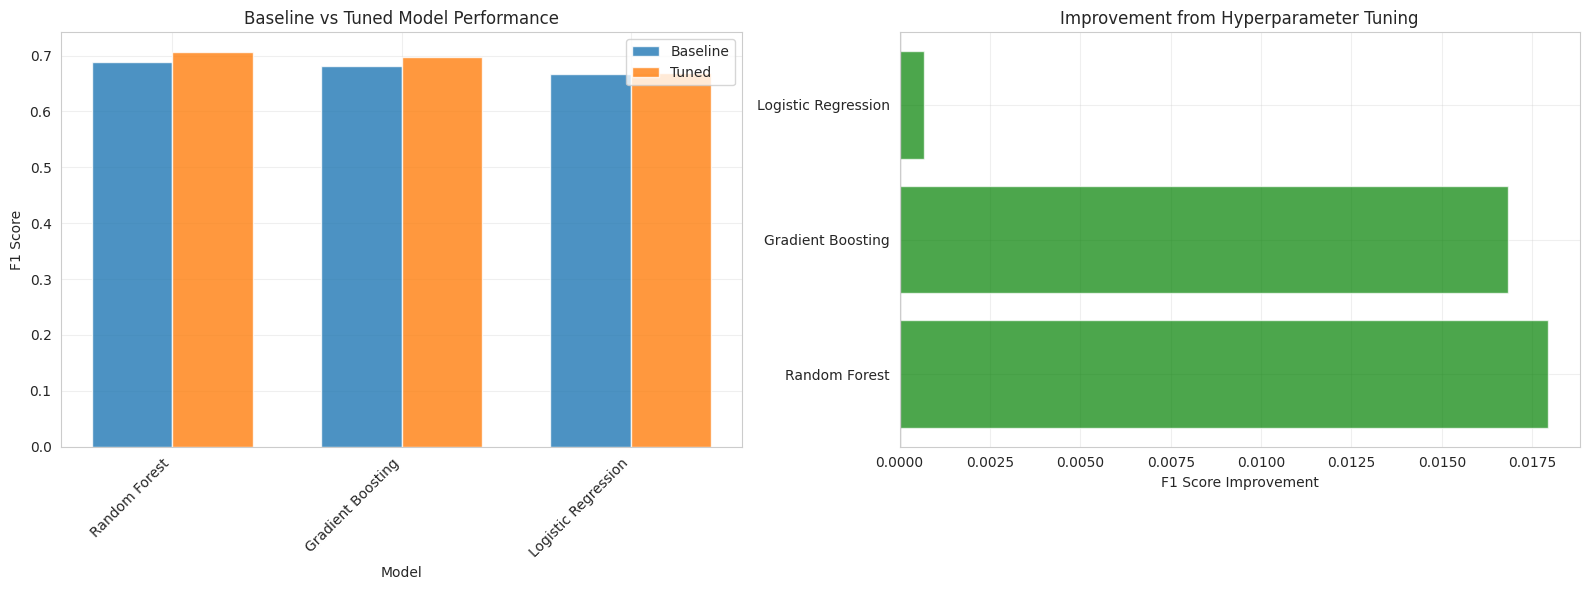

In [16]:
# Visualize improvements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Baseline vs Tuned
x_pos = np.arange(len(comparison_df))
width = 0.35

ax1.bar(x_pos - width/2, comparison_df['Baseline F1'], width, label='Baseline', alpha=0.8)
ax1.bar(x_pos + width/2, comparison_df['Tuned Val F1'], width, label='Tuned', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('F1 Score')
ax1.set_title('Baseline vs Tuned Model Performance')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Improvements
colors = ['green' if x > 0 else 'red' for x in comparison_df['Improvement']]
ax2.barh(comparison_df['Model'], comparison_df['Improvement'], color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('F1 Score Improvement')
ax2.set_title('Improvement from Hyperparameter Tuning')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Final Evaluation on Test Set

**IMPORTANT**: Only evaluate on test set AFTER hyperparameter tuning is complete.
The test set is for final, held-out evaluation only.

In [17]:
# Evaluate all tuned models on test set
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION (Held-Out)")
print("="*80)

test_results = []

for name, model in [("Random Forest", rf_best), ("Gradient Boosting", gb_best), ("Logistic Regression", lr_best)]:
    y_test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    print(f"\n{name}:")
    print("-" * 50)
    print(f"Test F1: {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['Not Prolonged', 'Prolonged']))
    
    test_results.append({
        'Model': name,
        'Test F1': test_f1,
    })

test_results_df = pd.DataFrame(test_results)
print("\n" + "="*80)
print("FINAL TEST RESULTS SUMMARY")
print("="*80)
print(test_results_df.to_string(index=False))
print("="*80)


FINAL TEST SET EVALUATION (Held-Out)

Random Forest:
--------------------------------------------------
Test F1: 0.7053

Classification Report:
               precision    recall  f1-score   support

Not Prolonged       0.86      0.83      0.84     30042
    Prolonged       0.53      0.60      0.57      9888

     accuracy                           0.77     39930
    macro avg       0.70      0.71      0.71     39930
 weighted avg       0.78      0.77      0.78     39930


Gradient Boosting:
--------------------------------------------------
Test F1: 0.6944

Classification Report:
               precision    recall  f1-score   support

Not Prolonged       0.83      0.93      0.88     30042
    Prolonged       0.66      0.42      0.51      9888

     accuracy                           0.80     39930
    macro avg       0.74      0.67      0.69     39930
 weighted avg       0.79      0.80      0.79     39930


Logistic Regression:
--------------------------------------------------
Test 

## 7. Export Best Hyperparameters

In [18]:
# Export best parameters for documentation
best_params_summary = {
    'Random Forest': rf_grid_search.best_params_,
    'Gradient Boosting': gb_random_search.best_params_,
    'Logistic Regression': lr_grid_search.best_params_,
}

# Save to CSV
best_params_df = pd.DataFrame([
    {'Model': model, 'Parameter': param, 'Value': value}
    for model, params in best_params_summary.items()
    for param, value in params.items()
])

output_path = 'data_samples/10_best_hyperparameters.csv'
best_params_df.to_csv(output_path, index=False)
print(f"Exported best hyperparameters to: {output_path}")

# Also save full comparison
comparison_output = 'data_samples/10_tuning_results.csv'
comparison_df.to_csv(comparison_output, index=False)
print(f"Exported tuning results to: {comparison_output}")

Exported best hyperparameters to: data_samples/10_best_hyperparameters.csv
Exported tuning results to: data_samples/10_tuning_results.csv


## 8. Recommendations

Based on the hyperparameter tuning results:

1. **Update centralized_models.py** with the best parameters from above
2. **Document improvements** - Note the F1 score gains from tuning
3. **Re-tune if needed** - If new features are added (PHASE 4), consider re-tuning
4. **Consider ensemble** - If multiple models perform similarly, try ensemble methods

**Next Steps**:
- Integrate best parameters into production code
- Test on new feature sets from PHASE 4
- Proceed to PHASE 6 (Federated Learning Implementation)